# 선형회귀 예시 2 
- 의료비에 영향을 미치는 요소

In [40]:

import numpy as np
from pandas import read_excel, DataFrame, melt, merge, get_dummies
from pca import pca
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

미국 환자의 의료비
|변수|	의미|	기타|
|--|--|--|
age	|수익자의 연령|	수치형
sex	|계약자의 성별|	범주형 데이터(female/male)
bmi	|비만도. 몸무게를 키의 제곱으로 나눈 값.	|수치형 정상범위: 18.5~24.9|
children|	의료보험이 적용되는 자녀 수	|수치형 데이터
smoker|	흡연 여부	|범주형 데이터(yes/no)
region|	거주지역	|범주형(북동: northeast, 남동: southeast / 남서: southwest / 북서: northwest)|
expense|	의료비|	수치형 데이터

In [41]:
origin = read_excel("https://data.hossam.kr/E04/insurance.xlsx")
origin

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## 데이터 전처리 

In [42]:
# 데이터 프레임 복사 후 결측치와 데이터 타입 확인
edf = origin.copy()
print('결측치 개수')
print(edf.isna().sum())
print('----------------------------')
print('데이터 타입')
print(edf.dtypes)


결측치 개수
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
----------------------------
데이터 타입
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


## 범주형 타입 변환



In [43]:
# 범주형 필드 이름
cnames = ['sex','smoker','region']
cnames

['sex', 'smoker', 'region']

In [44]:
def setCategory(df, fields=[], labelling=True):
    """
    데이터 프레임에서 지정된 필드를 범주형으로 변경한다.

    Parameters
    -------
    - df: 데이터 프레임
    - fields: 범주형으로 변경할 필드명 리스트. 기본값은 빈 리스트(전체 필드 대상)

    Returns
    -------
    - cdf: 범주형으로 변경된 데이터 프레임
    """
    cdf = df.copy()
    # 데이터 프레임의 변수명을 리스트로 변환
    ilist = list(cdf.dtypes.index)
    # 데이터 프레임의 변수형을 리스트로 변환
    vlist = list(cdf.dtypes.values)

    # 변수형에 대한 반복 처리
    for i, v in enumerate(vlist):
        # 변수형이 object이면?
        if v == 'object':
            # 변수명을 가져온다.
            field_name = ilist[i]

            # 대상 필드 목록이 설정되지 않거나(전체필드 대상), 현재 필드가 대상 필드목록에 포함되어 있지 않다면?
            if not fields or field_name not in fields:
                continue

            # 가져온 변수명에 대해 값의 종류별로 빈도를 카운트 한 후 인덱스 이름순으로 정렬
            #vc = cdf[field_name].value_counts().sort_index()
            # print(vc)

            # 인덱스 이름순으로 정렬된 값의 종류별로 반복 처리
            #for ii, vv in enumerate(list(vc.index)):
                # 일련번호값으로 치환
                #cdf.loc[cdf[field_name] == vv, field_name] = ii

            # 해당 변수의 데이터 타입을 범주형으로 변환
            cdf[field_name] = cdf[field_name].astype('category')
            
            if labelling:
                mydict = {}
                
                for i, v in enumerate(cdf[field_name].dtypes.categories):
                    mydict[v] = i
                
                print(mydict)
                cdf[field_name] = cdf[field_name].map(mydict).astype(int)

    return cdf

In [45]:
# 범주형 컬럼 타입 변환
edf2 = setCategory(edf, fields=cnames, labelling=False)
edf2.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

## 탐색적 데이터 분석

### 1. 수치형 변수

#### 1) 기초 통계량 확인

수치형 데이터 타입은 전체적인 통계값을 파악하는 것이 좋다.


In [46]:
desc = edf2.describe()
desc

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


의료비 지출 변수의 통계값을 살펴보면 charges의 중앙값이 9382고 평균이 13270임을 알수 있다. 평균값이 중앙값보다 크기 때문에 의료비 분포는 오른쪽으로 꼬리가 긴 분포가 될 것이다. 

2) 전체 상자 그림 확인

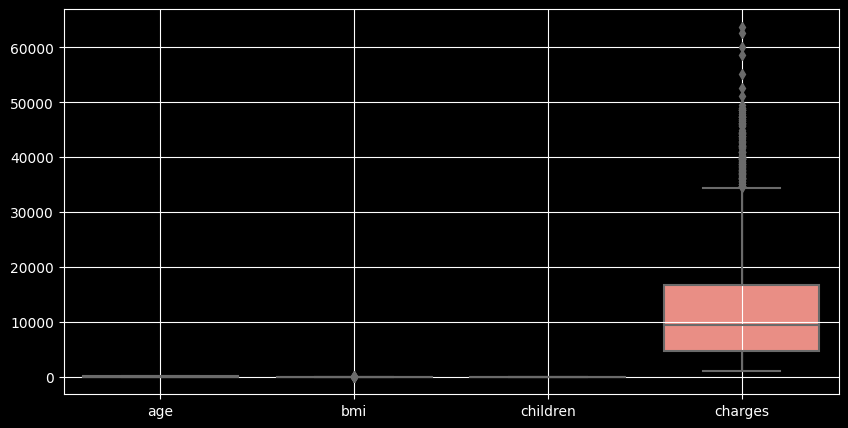

In [47]:
plt.figure(figsize=(10,5))
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

3) 개별 상자그림 확인

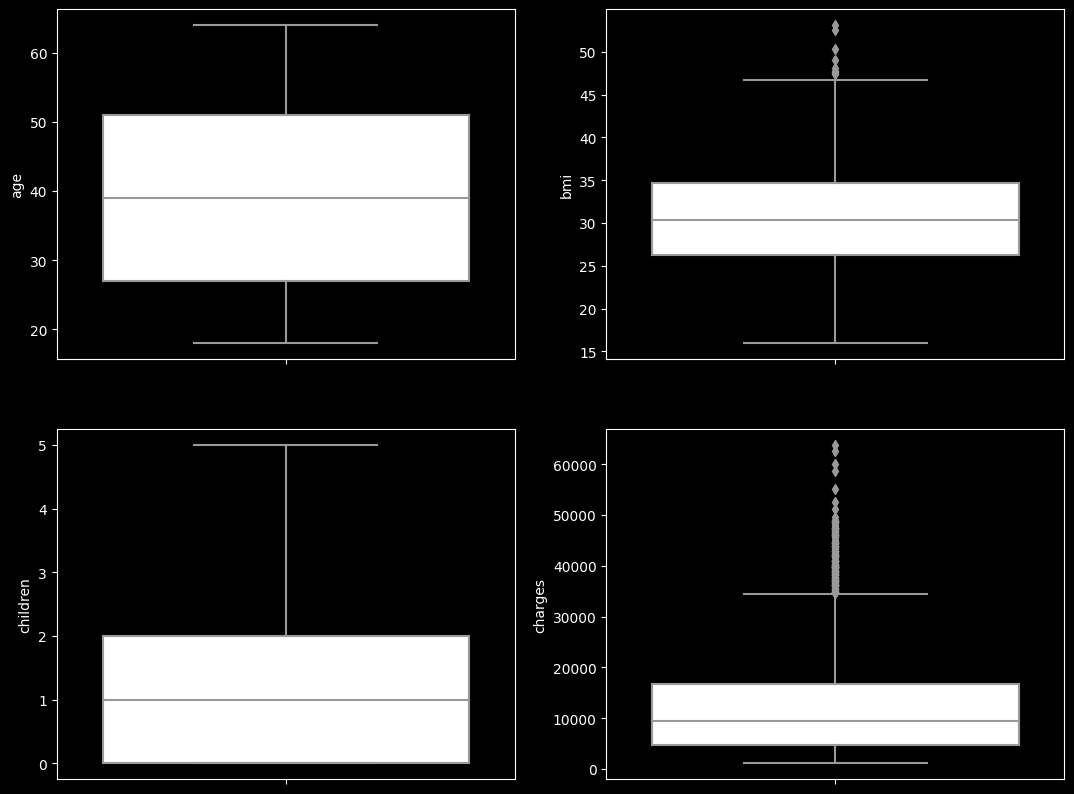

In [48]:
fig, ax = plt.subplots(2,2, figsize=(13,10))
rows = len(ax)
cols = len(ax[0])

for i in range(0,rows) :
    for j in range(0,cols) :
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]
        sb.boxplot(edf, y=field, ax =ax[i][j],color='white')

        if idx+1 == len(desc.columns):
            break
plt.show()
plt.close()

4. 히스토그램 확인

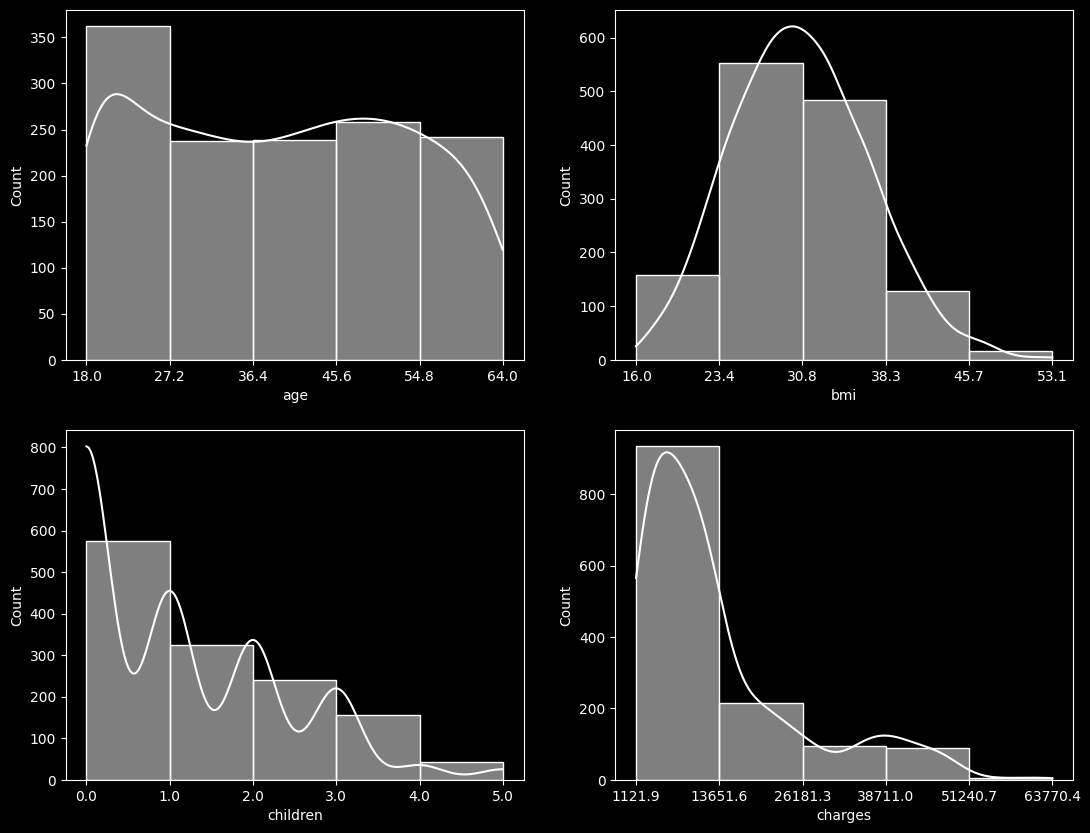

In [49]:
fig, ax = plt.subplots(2,2, figsize=(13,10))
rows = len(ax)
cols = len(ax[0])

for i in range(0,rows) :
    for j in range(0,cols) :
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]
        hist, bins = np.histogram(field, bins=5)
        bins2 = np.round(bins, 1)
        
        sb.histplot(data=edf2, x=fieldName, bins=5, kde=True, ax=ax[i][j], color='white')
        ax[i][j].set_xticks(bins2)
        ax[i][j].set_xticklabels(bins2)

        if idx+1 == len(desc.columns):
            break
plt.show()
plt.close()

대부분의 사람들은 연간 $15000 이하의 의료비 지출에 분포되어 있음을 알 수 있다. 마찬가지로 bmi 지수를 살펴보면 과제충 이상의 데이터가 절반 이상을 차지한다. 

In [50]:
# 수지형 변수들의 이름
nnames = list(desc.columns)
nnames

['age', 'bmi', 'children', 'charges']

In [51]:
ndf = edf.filter(nnames)
ndf.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


### 산점도 행렬

<Figure size 2000x2000 with 0 Axes>

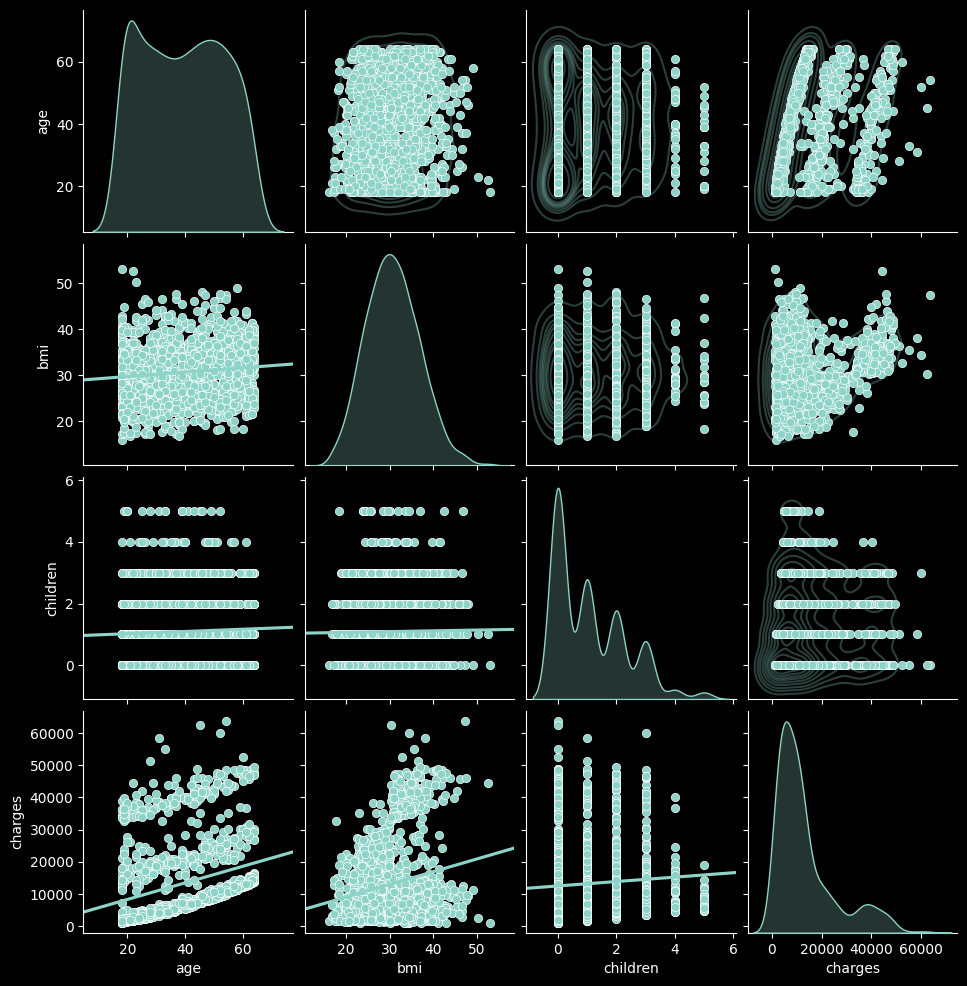

In [52]:
plt.figure(figsize=(20,20))
g = sb.pairplot(ndf,diag_kind='kde')
g.map_upper(sb.kdeplot,alpha = 0.3)
g.map_lower(sb.regplot, scatter = False, truncate = False, ci = False)
plt.show()
plt.close()


위 그래프 패턴에서 특정한 관계를 찾기는 어렵다. 
연령과 의료비 지출의 산포도를 보면 상대적으로 직선형태임을 볼 수 있다.
bmi 지수와 의료비 지출은 크게 2개의 군집으로 나뉘어져 있다.
전체적으로 강한 상관관계를 보이지 않지만 age-bmi, age-charges, children-charges가 약한 상관관계를 보인다.

나이가 들수록 살쪄서 bmi도 높아지도, 부양가족 수가 많으니까 의료비가 증가하니까. 뭐 


### 상관행렬

대각선은 변수 자신이기 때문에 항상 1이 표기된다.

상관계수는 1에 가까울수록 두 변수가 같은 방향으로 양의 상관관계가 높다고 판단할 수있고, -1에 가까울소록 음의 상관관계가 높다는 것을 나타낸다.

In [53]:
corr = ndf.corr(method='pearson')
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


모두 양의 상관관계를 가지고 있다. 
연령과 bmi 지수는 나이가 들어갈 수록 몸무게가 증가 되면서 bmi 지수가 높아지는 경향을 설명할 수 있고, 부양가족 수가 증가하면 의료비 지출이 많아진다고 보는 것도 합리적


### 5) PCA분석

회귀분석에 필요한 요인들을 선정하기위해 주성분 분석을 수행한다. 

### 데이터 표준화
범주형은 PCA를 수행할 수 없기 때문에 수치형 변수만 추출해 둔 ndf를 사용한다.

종속 변수인 의료비 필드는 제외하고 진행한다.





In [54]:

def scalling(df, yname=None):
    """
    데이터 프레임을 표준화 한다.

    Parameters
    -------
    - df: 데이터 프레임
    - yname: 종속변수 이름

    Returns
    -------
    - x_train_std_df: 표준화된 독립변수 데이터 프레임
    - y_train_std_df: 표준화된 종속변수 데이터 프레임
    """
    # 평소에는 yname을 제거한 항목을 사용
    # yname이 있지 않다면 df를 복사
    x_train = df.drop([yname], axis=1) if yname else df.copy()
    x_train_std = StandardScaler().fit_transform(x_train)
    x_train_std_df = DataFrame(x_train_std, columns=x_train.columns)
    
    if yname:
        y_train = df.filter([yname])
        y_train_std = StandardScaler().fit_transform(y_train)
        y_train_std_df = DataFrame(y_train_std, columns=y_train.columns)

    if yname:
        result = (x_train_std_df, y_train_std_df)
    else:
        result = x_train_std_df

    return result

In [55]:
x_train_std_df, y_train_std_df = scalling(ndf[nnames], 'charges')
x_train_std_df

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614
...,...,...,...
1333,0.768473,0.050297,1.580926
1334,-1.509965,0.206139,-0.908614
1335,-1.509965,1.014878,-0.908614
1336,-1.296362,-0.797813,-0.908614


### PCA 

In [56]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']

best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
print(best_names)

topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
['children', 'age']


,PC,feature,loading,type
0,PC1,age,0.692028,best
1,PC2,children,0.931148,best
2,PC3,age,-0.717326,best
3,PC3,bmi,0.669385,weak


근데 왜 bmi가 weak야? 

## 2.범주형 변수


### 1) 종류별로 데이터 수량 확인

In [57]:
for name in cnames :
    print(edf2[name].value_counts())
    print('----------------')

sex
male      676
female    662
Name: count, dtype: int64
----------------
smoker
no     1064
yes     274
Name: count, dtype: int64
----------------
region
southeast    364
northwest    325
southwest    325
northeast    324
Name: count, dtype: int64
----------------


### 2) 범주형 데이터의 데이터 분포 시각화

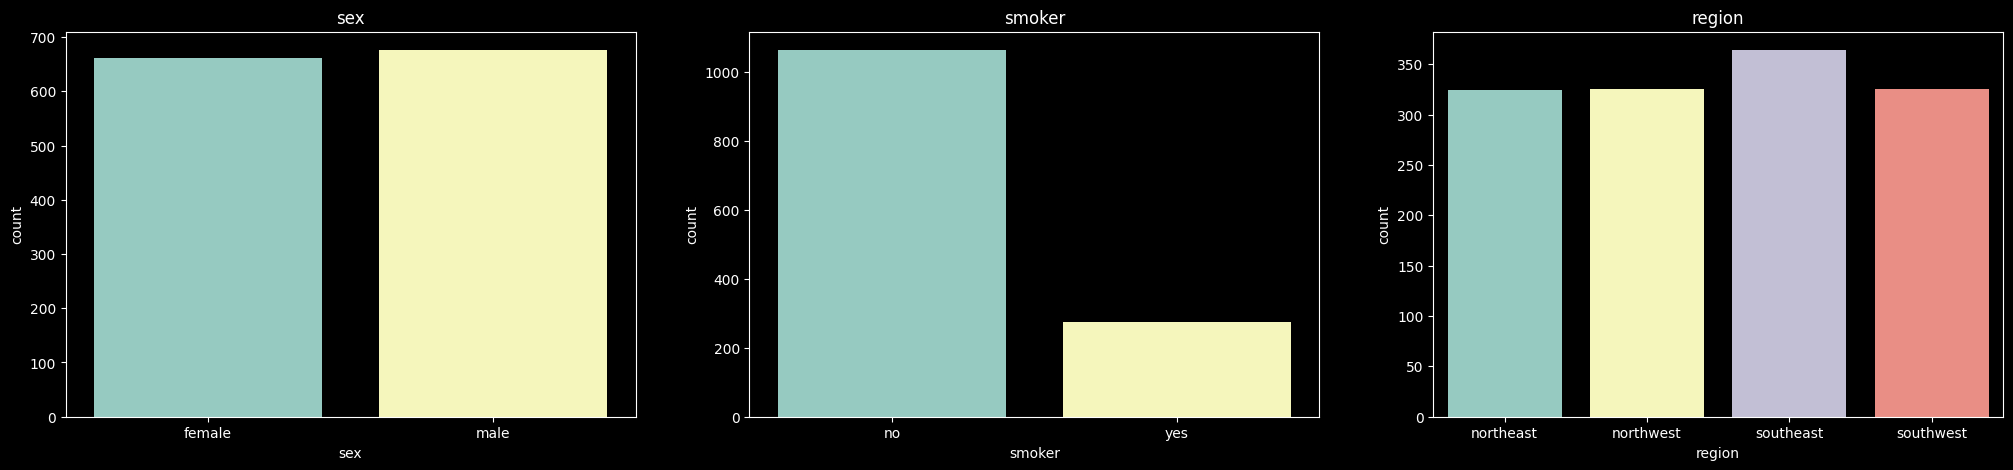

In [58]:
fig, ax = plt.subplots(1, len(cnames), figsize=(25, 5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf2[v].value_counts(), columns=['count'])
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)
    
plt.show()
plt.close()

비흡연자가 많다. 성별과 지역은 비슷한 분포를 보인다. 분산분석을 통해 통제 요인을 넣는 것을 고려해볼 수 있다.

3) 범주형 변수에 따라 평균이 차이가 나는지 확인하기

라벨링을 적용한 데이터프레임 생성


In [59]:
# 범주형 컬럼 타입 변환
ldf = setCategory(edf, fields=cnames, labelling=True)

{'female': 0, 'male': 1}
{'no': 0, 'yes': 1}
{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}


In [60]:
ldf.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

분산분석

In [61]:
lm = ols('charges ~ C(sex)+C(smoker)+C(region)+C(sex):C(smoker)+C(smoker):C(region)+C(region):C(sex)+C(sex):C(smoker):C(region)', data=ldf).fit()
lmdf = anova_lm(lm)
lmdf['결과'] = lmdf['PR(>F)'] < 0.05
lmdf

,df,sum_sq,mean_sq,F,PR(>F),결과
C(sex),1.0,6.435902e+08,6.435902e+08,11.730026,6.338371e-04,True
C(smoker),1.0,1.208777e+11,1.208777e+11,2203.108485,7.872124e-284,True
C(region),3.0,1.078004e+08,3.593345e+07,0.654920,5.799028e-01,False
C(sex):C(smoker),1.0,4.904163e+08,4.904163e+08,8.938290,2.844155e-03,True
C(smoker):C(region),3.0,1.344084e+09,4.480281e+08,8.165726,2.181106e-05,True
C(region):C(sex),3.0,1.382281e+06,4.607604e+05,0.008398,9.989439e-01,False
C(sex):C(smoker):C(region),3.0,7.517058e+07,2.505686e+07,0.456684,7.126143e-01,False
Residual,1322.0,7.253404e+10,5.486690e+07,NaN,NaN,False


성별과 흡연 여부에 대한 p값이 모두 0.05미만이므로 두 요인은 의료비 지출에 통계적으로 유의미한 영향을 미친다.

성별과 흡연량, 흡연량과 지역간에는 교호 작용(한 요인의 효과가 다른 요인의 수준에 의존하는 경우) 효과가 있음을 발견되었다. 

교호작용을 보이는 변수간의 비교

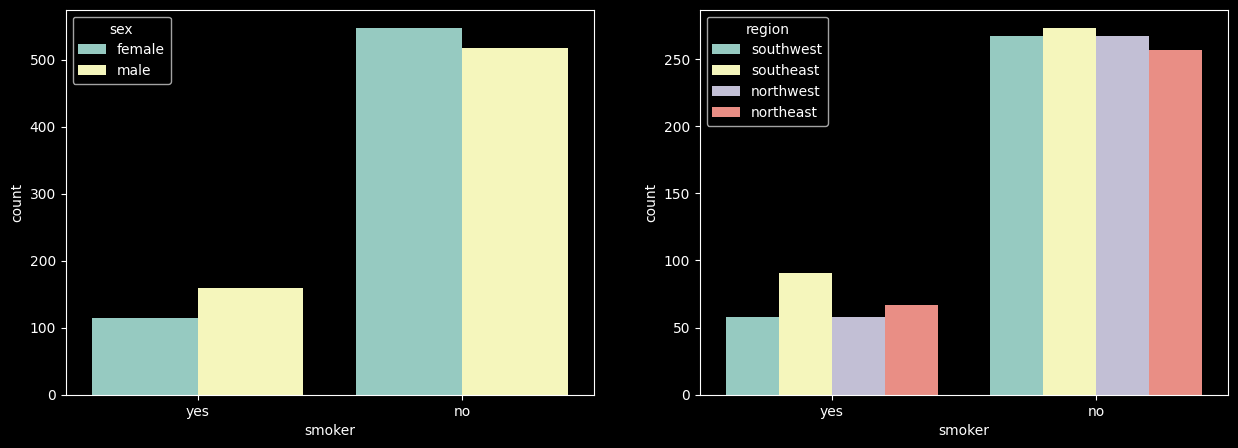

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sb.countplot(data=edf, x='smoker',hue='sex',ax=ax1)
sb.countplot(data=edf, x='smoker',hue='region',ax=ax2)

plt.show()
plt.close()

### 04. 최종적으로 선정된 요인


|구분|	변수|	의미|	기타|
|--|--|--|--|
종속변수|	expense|	의료비	|수치형 데이터
독립변수|	age	|수익자의 연령	|수치형
독립변수|	bmi|	미만도. 몸무게를 키의 제곱으로 나눈 값.	|수치형 정상범위: 18.5~24.9
독립변수|	children|	의료보험이 적용되는 자녀 수	|수치형 데이터
통제요인|	sex	|계약자의 성별|	범주형 데이터(female/male)
통제요인|	smoker|	흡연 여부	|범주형 데이터(yes/no)


### 다중선형회귀 분석

- case1 : 모든 변수 적용
- case2 : bmi를 제거하고 적용
- case3 : 모든 변수 적용 + 표준화 적용
- case4 : bmi를 제거 후 적용 + 표준화 적용

#### 분석 케이스에 따른 분석용 데이터 생성

In [63]:


def get_df(case_number, is_scale=False):
    # bmi를 제거하지 않은 경우
    if case_number == 1:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # bmi를 제거한 경우
    elif case_number == 2:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # 성별을 제거한 경우
    elif case_number == 3:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
    # 성별과 bmi을 제거한 경우
    elif case_number == 4:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
        
    # 표준화를 적용하지 않은 경우
    if not is_scale:
        tmp = origin.filter(fnames1)
    # 표준화를 적용한 경우
    else:
        # 미리 적용해 둔 표준화 결과를 병합
        left = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True).filter(fnames1)
        # 원본에서 명목형만 다시 추출
        right = origin.filter(fnames2)
        # 결합
        tmp = merge(left, right, left_index=True, right_index=True)
        None
        
    tmp2 = get_dummies(tmp, columns=fnames2, drop_first=True, dtype='int')
    return tmp2

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas import MultiIndex, DatetimeIndex, Series



class OlsResult:
    def __init__(self):
        self._model = None
        self._fit = None
        self._summary = None
        self._table = None
        self._result = None
        self._goodness = None
        self._varstr = None

    @property
    def model(self):
        """
        분석모델
        """
        return self._model

    @model.setter
    def model(self, value):
        self._model = value

    @property
    def fit(self):
        """
        분석결과 객체
        """
        return self._fit

    @fit.setter
    def fit(self, value):
        self._fit = value

    @property
    def summary(self):
        """
        분석결과 요약 보고
        """
        return self._summary

    @summary.setter
    def summary(self, value):
        self._summary = value

    @property
    def table(self):
        """
        결과표
        """
        return self._table

    @table.setter
    def table(self, value):
        self._table = value

    @property
    def result(self):
        """
        결과표 부가 설명
        """
        return self._result

    @result.setter
    def result(self, value):
        self._result = value

    @property
    def goodness(self):
        """
        모형 적합도 보고
        """
        return self._goodness

    @goodness.setter
    def goodness(self, value):
        self._goodness = value

    @property
    def varstr(self):
        """
        독립변수 보고
        """
        return self._varstr

    @varstr.setter
    def varstr(self, value):
        self._varstr = value



def myOls(data, y=None, x=None, expr=None):
    """
    로지스틱 회귀분석을 수행한다.

    Parameters
    -------
    - data : 데이터 프레임
    - y: 종속변수 이름
    - x: 독립변수의 이름들(리스트)
    """

    # 데이터프레임 복사
    df = data.copy()

    # 종속변수~독립변수1+독립변수2+독립변수3+... 형태의 식을 생성
    if not expr:
        # 독립변수의 이름이 리스트가 아니라면 리스트로 변환
        if type(x) != list:
            x = [x]
        expr = "%s~%s" % (y, "+".join(x))
    else:
        x = []
        p = expr.find('~')
        y = expr[:p].strip()
        x_tmp = expr[p+1:]
        x_list = x_tmp.split('+')
            
        for i in x_list:
            k = i.strip()
                
            if k:
                x.append(k)

    # 회귀모델 생성
    model = ols(expr, data=data)
    # 분석 수행
    fit = model.fit()

    # 파이썬 분석결과를 변수에 저장한다.
    summary = fit.summary()

    # 첫 번째, 세 번째 표의 내용을 딕셔너리로 분해
    my = {}

    for k in range(0, 3, 2):
        items = summary.tables[k].data
        # print(items)

        for item in items:
            # print(item)
            n = len(item)

            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()

                if key and value:
                    my[key] = value

    # 두 번째 표의 내용을 딕셔너리로 분해하여 my에 추가
    my['variables'] = []
    name_list = list(data.columns)
    #print(name_list)

    for i, v in enumerate(summary.tables[1].data):
        if i == 0:
            continue

        # 변수의 이름
        name = v[0].strip()

        vif = 0

        # Intercept는 제외
        if name in name_list:
            # 변수의 이름 목록에서 현재 변수가 몇 번째 항목인지 찾기 
            j = name_list.index(name)
            vif = variance_inflation_factor(data, j)

        my['variables'].append({
            "name": name,
            "coef": v[1].strip(),
            "std err": v[2].strip(),
            "t": v[3].strip(),
            "P-value": v[4].strip(),
            "Beta": 0,
            "VIF": vif,
        })

    # 결과표를 데이터프레임으로 구성
    mylist = []
    yname_list = []
    xname_list = []

    for i in my['variables']:
        if i['name'] == 'Intercept':
            continue

        yname_list.append(y)
        xname_list.append(i['name'])

        item = {
            "B": i['coef'],
            "표준오차": i['std err'],
            "β": i['Beta'],
            "t": "%s*" % i['t'],
            "유의확률": i['P-value'],
            "VIF": i["VIF"]
        }

        mylist.append(item)

    table = DataFrame(mylist,
                   index=MultiIndex.from_arrays([yname_list, xname_list], names=['종속변수', '독립변수']))
    
    # 분석결과
    result = "𝑅(%s), 𝑅^2(%s), 𝐹(%s), 유의확률(%s), Durbin-Watson(%s)" % (my['R-squared'], my['Adj. R-squared'], my['F-statistic'], my['Prob (F-statistic)'], my['Durbin-Watson'])

    # 모형 적합도 보고
    goodness = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p < 0.05)." % (y, ",".join(x), "유의하다" if float(my['Prob (F-statistic)']) < 0.05 else "유의하지 않다", my['Df Model'], my['Df Residuals'], my['F-statistic'])

    # 독립변수 보고
    varstr = []

    for i, v in enumerate(my['variables']):
        if i == 0:
            continue
        
        s = "%s의 회귀계수는 %s(p%s0.05)로, %s에 대하여 %s."
        k = s % (v['name'], v['coef'], "<" if float(v['P-value']) < 0.05 else '>', y, '유의미한 예측변인인 것으로 나타났다' if float(v['P-value']) < 0.05 else '유의하지 않은 예측변인인 것으로 나타났다')

        varstr.append(k)

    ols_result = OlsResult()
    ols_result.model = model
    ols_result.fit = fit
    ols_result.summary = summary
    ols_result.table = table
    ols_result.result = result
    ols_result.goodness = goodness
    ols_result.varstr = varstr

    return ols_result



In [65]:
target_df = get_df(3, True)
print(target_df.head())

# 독립변수 이름만 추출
xnames = list(target_df.columns)
xnames.remove('charges')
#xnames

ols_result = myOls(target_df, y='charges', x=xnames)

print(ols_result.table)
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

    charges       age       bmi  children  smoker_yes
0  0.298584 -1.438764 -0.453320 -0.908614           1
1 -0.953689 -1.509965  0.509621 -0.078767           0
2 -0.728675 -0.797954  0.383307  1.580926           0
3  0.719843 -0.441948 -1.305531 -0.908614           0
4 -0.776802 -0.513149 -0.292556 -0.908614           0
                         B   표준오차  β        t   유의확률       VIF
종속변수    독립변수                                                  
charges age         0.2992  0.014  0  21.675*  0.000  1.243647
        bmi         0.1621  0.014  0  11.756*  0.000  1.082342
        children    0.0471  0.014  0   3.436*  0.001  1.008148
        smoker_yes  1.9670  0.034  0  57.904*  0.000  2.321101
𝑅(0.750), 𝑅^2(0.749), 𝐹(998.1), 유의확률(0.00), Durbin-Watson(2.087)

charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 998.1, p < 0.05).

age의 회귀계수는 0.2992(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1621(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났

### 3. 결과 비교

#### 1) 나이에 따른 의료비 지출

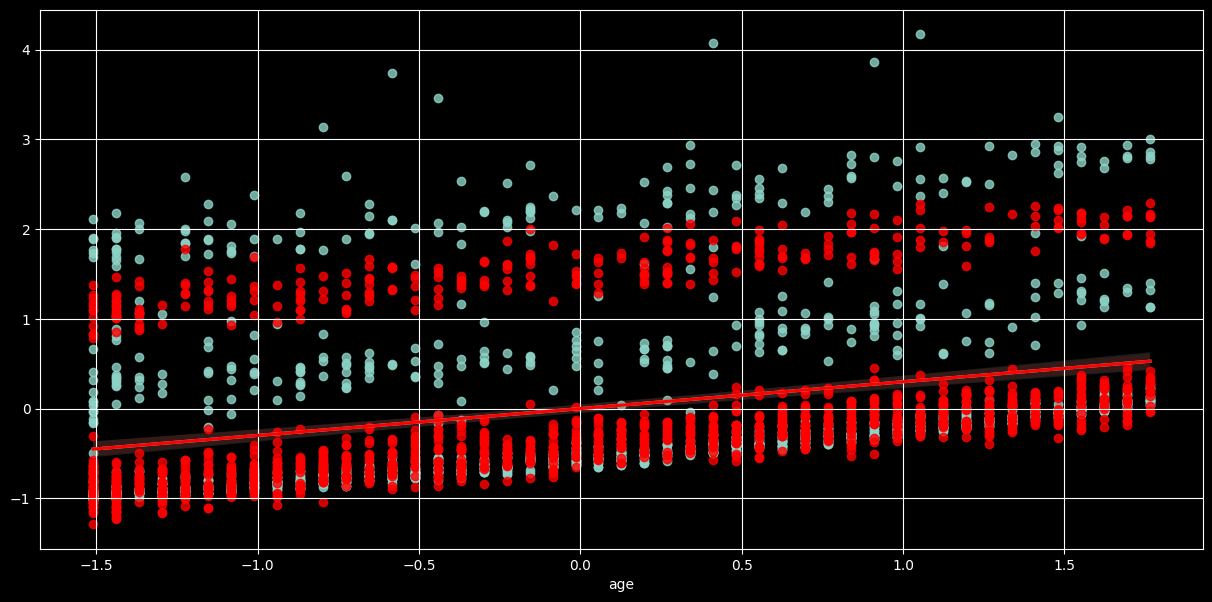

In [66]:
plt.figure(figsize=(15,7))
sb.regplot(data=target_df,x='age',y='charges')
sb.regplot(data=target_df,x='age',y=ols_result.fit.fittedvalues,color='red')
plt.grid()
plt.show()
plt.close()

### 2) BMI에 따른 의료비 지출 비교

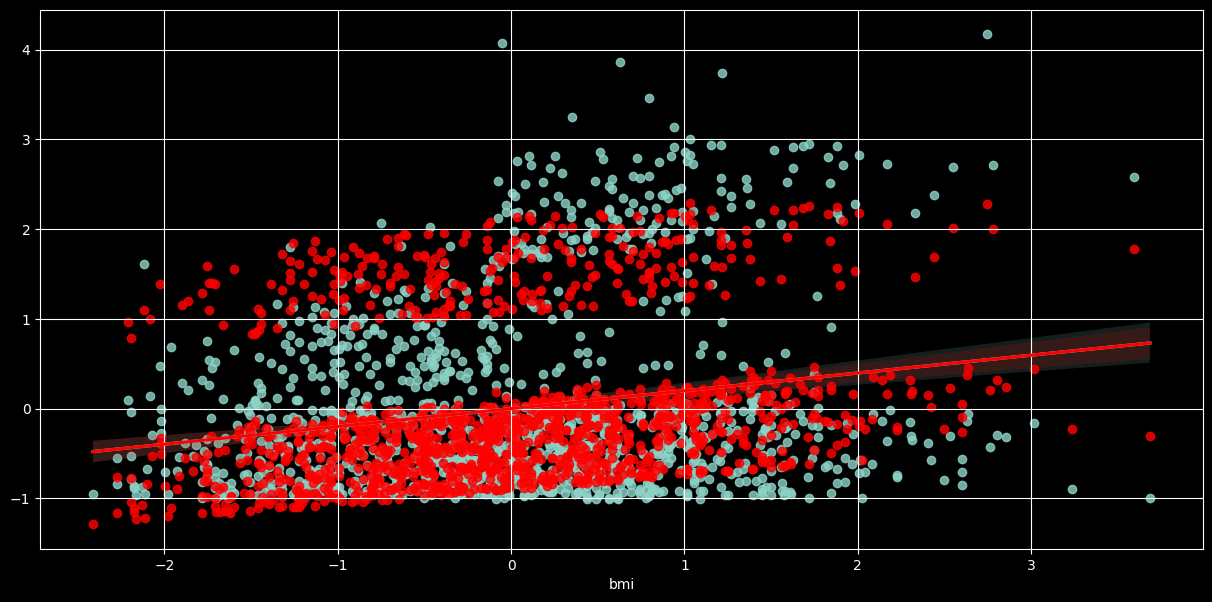

In [67]:
plt.figure(figsize=(15,7))
sb.regplot(data=target_df,x='bmi',y='charges')
sb.regplot(data=target_df,x='bmi',y=ols_result.fit.fittedvalues,color='red')
plt.grid()
plt.show()
plt.close()

## 데이터 도메인 지식

도메인 지식이란 특정 분야의 전문화된 지식을 말한다. ex) 노하우

도메인 지식을 활용하면 도출된 분석모델의 성능을 개선할 수 있다.


### 1. 의료비 지출

연령은 의료비 지출에 대해 일정하지 않다. 20-30대와 70대 이상의 의료비 지출은 크게 날 수 밖에 없다. (노하우)

기존의 연령 변수는 전형적인 선형회귀 방정식을 따른다. 

$y = a_1x + b$ 

하지만 고연령대일수록 증가폭이 커지는 현상을 설명하기 위해서는 높은 차수의 항을 회귀 모델에 추가해서 다항식으로 만들어 주면 된다.

$y = {a_2}^2x + {a_1}x + b$

### 연령을 제곱한 형태로 연령 변수 교체

In [68]:
tmp_df = DataFrame({'age2':origin['age'] **2}, index = origin.index)
age2_std = StandardScaler().fit_transform(tmp_df)
target_df['age'] = age2_std
target_df.head()

,charges,age,bmi,children,smoker_yes
0,0.298584,-1.220462,-0.453320,-0.908614,1
1,-0.953689,-1.253341,0.509621,-0.078767,0
2,-0.728675,-0.844579,0.383307,1.580926,0
3,0.719843,-0.573551,-1.305531,-0.908614,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0


회귀분석 수행

In [70]:
xnames = list(target_df.columns) # ['charges', 'age', 'bmi', 'children', 'smoker_yes']
xnames.remove('charges')

ols_result = myOls(target_df, y='charges', x=xnames)
ols_result.table

B   표준오차  β        t   유의확률       VIF
종속변수    독립변수                                                  
charges age         0.3036  0.014  0  22.129*  0.000  1.251226
        bmi         0.1603  0.014  0  11.689*  0.000  1.082276
        children    0.0608  0.014  0   4.464*  0.000  1.010457
        smoker_yes  1.9679  0.034  0  58.247*  0.000  2.331466

In [71]:
ols_result.result

'𝑅(0.752), 𝑅^2(0.752), 𝐹(1013.), 유의확률(0.00), Durbin-Watson(2.094)'

In [78]:
print(ols_result.goodness, end="\n\n")

# charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 1013., p < 0.05).

In [79]:
for i in ols_result.varstr :
    print(i)

age의 회귀계수는 0.3036(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1603(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0608(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9679(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


### 2. 비만도(bmi)

BMI는 특저 ㅇ구간에서의 영향은 적지만 그 구간을 넘어가면 강한 영향을 미친다.

EDA(탐색적 데이터 분석)을 진행하는 과정에서 BMI가 30 이상인 사람과 30 미만인 사람들을 구분할 수 있음을 파악하였다.

이 내용을 더미변수로 추가할 수 있다. (정상/비만)


#### BMI에 대한 비만도 파생 변수 만들기

In [82]:
tmp_df = origin.filter(['bmi'])
# 30이 넘어가면 int로 바꿔라 (false/True가 0과 1됨)
tmp_df['obesity'] = tmp_df['bmi'] >= 30  
tmp_df['obesity'] = tmp_df['obesity'].astype(int) 
tmp_df


,bmi,obesity
0,27.900,0
1,33.770,1
2,33.000,1
3,22.705,0
4,28.880,0
...,...,...
1333,30.970,1
1334,31.920,1
1335,36.850,1
1336,25.800,0


파생변수를 원래의 데이터프레임에 결합

In [83]:
target_df['obesity'] = tmp_df['obesity']
target_df.head()

,charges,age,bmi,children,smoker_yes,obesity
0,0.298584,-1.220462,-0.453320,-0.908614,1,0
1,-0.953689,-1.253341,0.509621,-0.078767,0,1
2,-0.728675,-0.844579,0.383307,1.580926,0,1
3,0.719843,-0.573551,-1.305531,-0.908614,0,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0,0


### 회귀분석 수행

In [87]:
xnames = list(target_df.columns)
xnames.remove('charges')
ols_result = myOls(target_df, y='charges', x=xnames)
ols_result.table

B   표준오차  β        t   유의확률       VIF
종속변수    독립변수                                                  
charges age         0.3032  0.014  0  22.302*  0.000  1.313720
        bmi         0.0685  0.023  0   3.043*  0.002  1.920042
        children    0.0609  0.014  0   4.509*  0.000  1.012493
        smoker_yes  1.9684  0.033  0  58.813*  0.000  3.388612
        obesity     0.2304  0.045  0   5.119*  0.000  2.082544

In [88]:
print(ols_result.result, end="\n\n")
print(ols_result.goodness, end="\n\n")
for i in ols_result.varstr:
    print(i)

𝑅(0.757), 𝑅^2(0.756), 𝐹(830.8), 유의확률(0.00), Durbin-Watson(2.098)

charges에 대하여 age,bmi,children,smoker_yes,obesity로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,1332) = 830.8, p < 0.05).

age의 회귀계수는 0.3032(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.0685(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0609(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9684(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
obesity의 회귀계수는 0.2304(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


## 3.교효작용 추가

#### 비만도와 흡연여부

In [92]:
xnames = list(target_df.columns)
xnames.remove('charges')
ols_result = myOls(target_df,expr="charges~age+bmi+children+smoker_yes+obesity+bmi*smoker_yes")
ols_result.table

B   표준오차  β        t   유의확률       VIF
종속변수    독립변수                                                       
charges age              0.3109  0.011  0  28.781*  0.000  1.313720
        bmi             -0.0981  0.019  0  -5.203*  0.000  1.920042
        children         0.0648  0.011  0   6.041*  0.000  1.012493
        smoker_yes       1.9651  0.027  0  73.902*  0.000  3.388612
        obesity          0.2476  0.036  0   6.925*  0.000  2.082544
        bmi:smoker_yes   0.7242  0.026  0  27.919*  0.000  0.000000

In [93]:
ols_result.result

'𝑅(0.847), 𝑅^2(0.846), 𝐹(1227.), 유의확률(0.00), Durbin-Watson(2.098)'

In [94]:

ols_result.goodness

'charges에 대하여 age,bmi,children,smoker_yes,obesity,bmi*smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,1331) = 1227., p < 0.05).'

In [95]:

for i in ols_result.varstr :
    print(i)

age의 회귀계수는 0.3109(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 -0.0981(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0648(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9651(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
obesity의 회귀계수는 0.2476(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi:smoker_yes의 회귀계수는 0.7242(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


최종 결과 비교

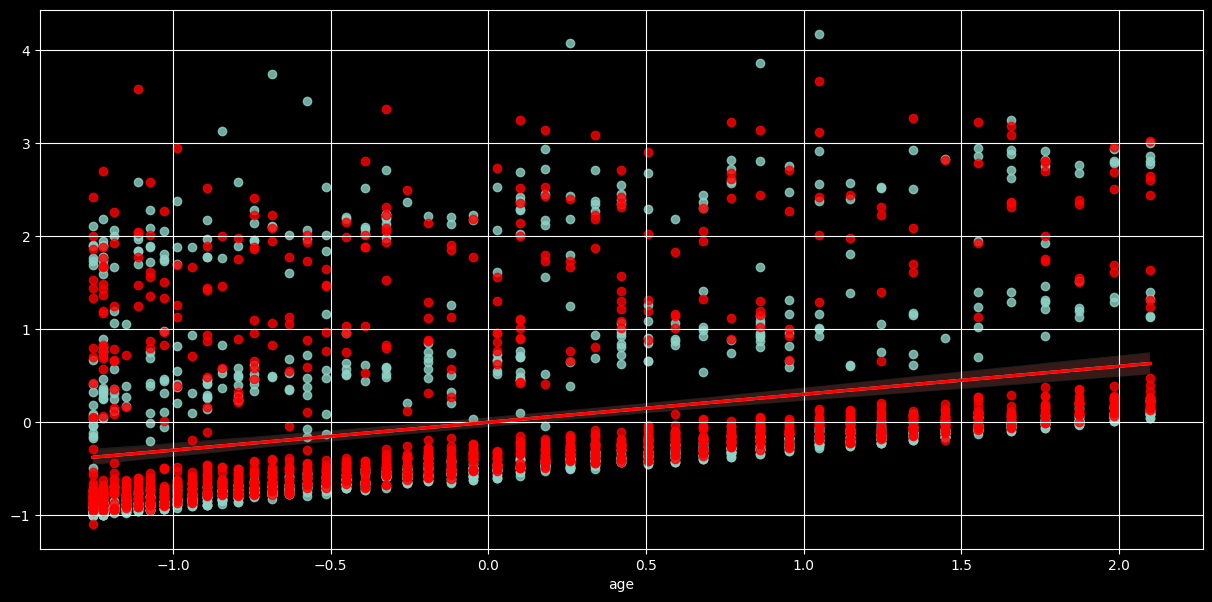

In [96]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='age', y='charges')
sb.regplot(data=target_df, x='age', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()